# Smoothing

## Preparation

In [5]:
# Define box smoothing function
box_smooth <- function(signal, k = 5, window_size = 3) {
  smoothed <- signal
  
  for (iteration in 1:k) {
    n <- length(smoothed)
    temp <- numeric(n)
    
    for (i in 1:n) {
      start <- max(1, i - floor(window_size/2))
      end <- min(n, i + floor(window_size/2))
      temp[i] <- mean(smoothed[start:end], na.rm = TRUE)
    }
    
    smoothed <- temp
  }
  
  return(smoothed)
}

In [12]:
# Apply smoothing to all curves in sim_data
sim_data_smooth <- sim_data %>%
  group_by(id) %>%
  mutate(y_smooth = box_smooth(y, k = 10, window_size = 3)) %>%
  ungroup()

In [13]:
# Check results
cat("Data after smoothing:\n")
cat("Total rows:", nrow(sim_data_smooth), "\n")
cat("Number of IDs:", length(unique(sim_data_smooth$id)), "\n")
cat("New columns:", names(sim_data_smooth), "\n")

Data after smoothing:
Total rows: 7500 
Number of IDs: 100 
New columns: id t y x1 x2 x3 y_smooth 


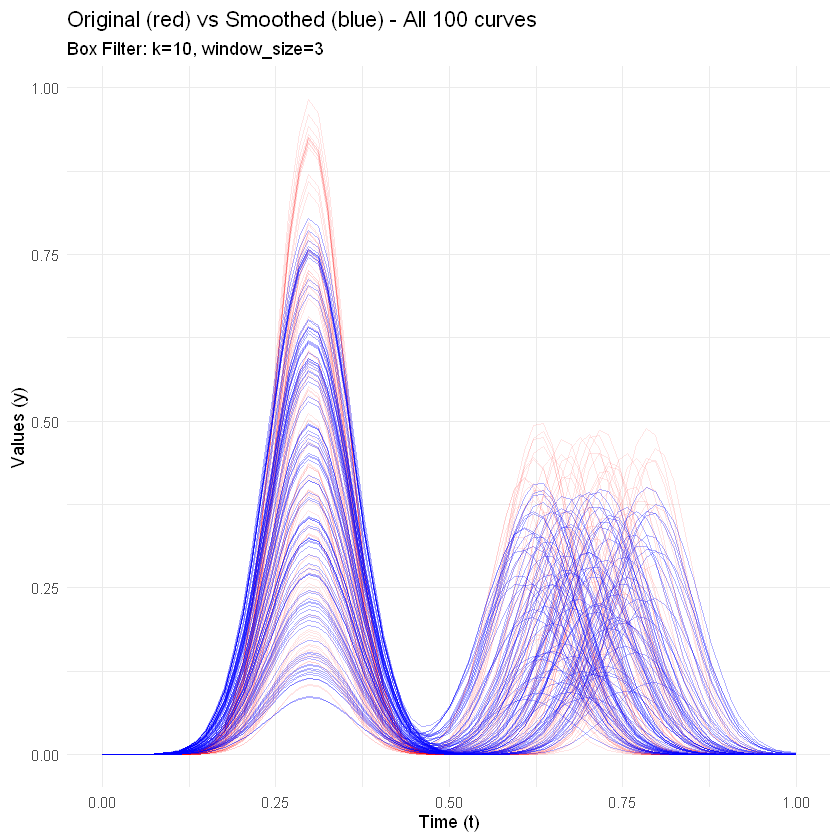

In [14]:
# Visualize all curves - before vs after smoothing
ggplot(sim_data_smooth, aes(x = t)) +
  geom_line(aes(y = y, group = id), color = "red", alpha = 0.1, linewidth = 0.3) +
  geom_line(aes(y = y_smooth, group = id), color = "blue", alpha = 0.3, linewidth = 0.3) +
  labs(title = "Original (red) vs Smoothed (blue) - All 100 curves",
       subtitle = "Box Filter: k=10, window_size=3",
       x = "Time (t)", 
       y = "Values (y)") +
  theme_minimal()

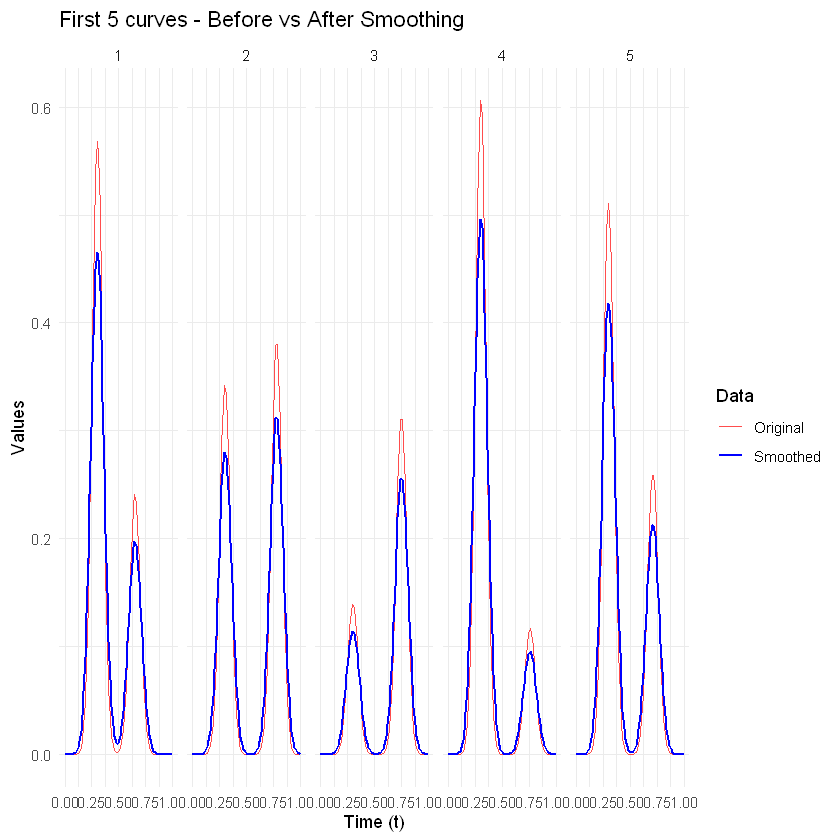

In [15]:
# Detailed view of first 5 curves
first_5_ids <- head(unique(sim_data_smooth$id), 5)

sim_data_smooth %>%
  filter(id %in% first_5_ids) %>%
  ggplot(aes(x = t)) +
  geom_line(aes(y = y, color = "Original"), linewidth = 0.5, alpha = 0.7) +
  geom_line(aes(y = y_smooth, color = "Smoothed"), linewidth = 0.8) +
  facet_wrap(~id, nrow = 1) +
  scale_color_manual(values = c("Original" = "red", "Smoothed" = "blue")) +
  labs(title = "First 5 curves - Before vs After Smoothing",
       x = "Time (t)", 
       y = "Values",
       color = "Data") +
  theme_minimal()


## Train - Test Split

In [16]:
set.seed(23020534)
id = unique(sim_data$id)
M_test = length(id) * 0.25 # train 75%, test 25%
id_test = sample(x = id, size = M_test, replace = FALSE)
sim_data_smooth = sim_data_smooth %>% mutate(dataset = ifelse(id %in% id_test, "test", "train"))
sim_data = sim_data %>% mutate(dataset = ifelse(id %in% id_test, "test", "train"))

In [17]:
table(sim_data$dataset)
length(unique(sim_data$id[sim_data$dataset == "test"]))
length(unique(sim_data$id[sim_data$dataset == "train"]))


 test train 
 1875  5625 

[1] 25

[1] 75

In [18]:
prep_matrix <- function(df, train_test) {
  df %>%
    filter(dataset == train_test) %>%
    select(id, t, y) %>%
    ungroup() %>%
    pivot_wider(id_cols = t,
                names_from = id,
                values_from = y) %>%
    select(-t) %>%
    as.matrix()
}

In [19]:
sim_train_matrix = prep_matrix(df = sim_data_smooth, train_test = "train")

# no smoothing -> avoiding data leakage
sim_test_matrix = prep_matrix(df = sim_data, train_test = "test") 
 
times = sim_data_smooth$t %>% unique()

In [20]:
# First 10 columns and 5 rows
sim_train_matrix[1:5, 1:10]

4,5,6,7,8,10,12,13,14,15
9.238582e-09,7.794835e-09,1.498210e-08,1.327075e-08,1.123399e-08,1.175081e-08,1.148047e-08,1.084557e-08,4.584835e-09,1.154231e-08
4.508218e-08,3.803702e-08,7.310926e-08,6.475823e-08,5.481933e-08,5.734130e-08,5.602208e-08,5.292390e-08,2.237295e-08,5.632384e-08
2.044942e-07,1.725372e-07,3.316260e-07,2.937454e-07,2.486622e-07,2.601019e-07,2.541180e-07,2.400645e-07,1.014844e-07,2.554868e-07
8.622508e-07,7.275038e-07,1.398302e-06,1.238579e-06,1.048486e-06,1.096721e-06,1.071490e-06,1.012233e-06,4.279095e-07,1.077261e-06
3.379580e-06,2.851441e-06,5.480627e-06,4.854593e-06,4.109524e-06,4.298583e-06,4.199689e-06,3.967434e-06,1.677186e-06,4.222310e-06


In [21]:
sim_test_matrix[1:5, 1:10]

1,2,3,9,11,18,23,26,27,29
8.668609e-09,5.213015e-09,2.126122e-09,1.195651e-08,3.615774e-09,5.045335e-09,5.333064e-09,1.099315e-08,8.359098e-09,1.073088e-08
4.230084e-08,2.543833e-08,1.037499e-08,5.834505e-08,1.764415e-08,2.462009e-08,2.602414e-08,5.364405e-08,4.079050e-08,5.236427e-08
1.918780e-07,1.153891e-07,4.706130e-08,2.646550e-07,8.003444e-08,1.116775e-07,1.180463e-07,2.433311e-07,1.850270e-07,2.375260e-07
8.090543e-07,4.865386e-07,1.984342e-07,1.115919e-06,3.374656e-07,4.708887e-07,4.977429e-07,1.026007e-06,7.801672e-07,1.001529e-06
3.171077e-06,1.906981e-06,7.777601e-07,4.373830e-06,1.322692e-06,1.845642e-06,1.950896e-06,4.021420e-06,3.057855e-06,3.925481e-06


In [22]:
cat("sim_train_matrix dim:", dim(sim_train_matrix), "\n")
cat("sim_test_matrix dim:", dim(sim_test_matrix), "\n") 
cat("times length:", length(times), "\n")
cat("Any NA in train:", any(is.na(sim_train_matrix)), "\n")
cat("Any NA in test:", any(is.na(sim_test_matrix)), "\n")

sim_train_matrix dim: 75 75 
sim_test_matrix dim: 75 25 
times length: 75 
Any NA in train: FALSE 
Any NA in test: FALSE 
